# Exploring the data

My impressions so far:

* The biggest challenge is dealing with the Breed, Color and Name variables
* Many of the variables are going to have interactions with one another, especially the AnimalType variable, therefore it may be useful to use a model that automatically considers feature interactions (ex. a Random Forest) over a model that requires us to manually create feature interactins (ex. Logistic Regression)
* Not a huge number of missing values in the training set, save for animal name, where not knowing the animal's name (or the animal not having a name) certainly tells us something useful...it may be worth imputing neutered and gender

Data cleaning / feature engineering overview:

* Split `SexuponOutcome` into separate neutered and gender features
* `AgeuponOutcome` is converted into a numeric feature
* `DateTime` is converted into a set of date-specific features (year, month, day of the week, etc.)
* The 1380 breeds are reduced into a smaller set of features
* The 300... colors are reduced into a smaller set of features

In [31]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

train = pd.read_csv('train.csv')

## Overview

See what the data look like.

In [32]:
print 'Number of training observations:', len(train.index)
train.head()

Number of training observations: 26729


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Missing values by column:

In [33]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

## Examining the dependent variable, `OutcomeType`

What happened to the animals?

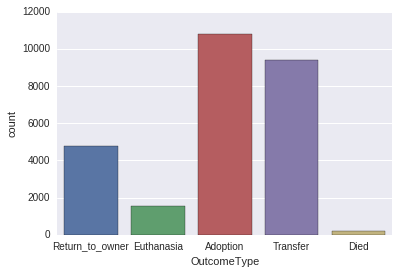

In [34]:
sns.countplot(x = "OutcomeType", data = train)

## Examining the independent variables

### `AnimalType`

Whether it's a cat or a dog.

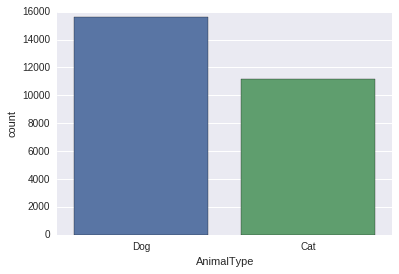

In [35]:
sns.countplot(x = "AnimalType", data = train)

`OutcomeType` by `AnimalType`

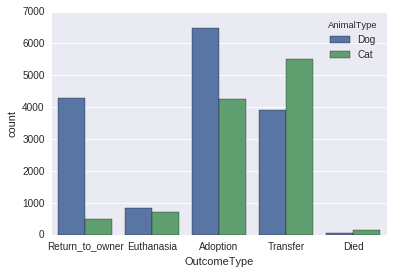

In [36]:
sns.countplot(x = "OutcomeType", hue = "AnimalType", data = train)

Visually, there looks to be a strong relationship between the outcome and what kind of animal there is - dogs are much more frequently returned to their owners, cats are more likely to die, etc.

### `SexuponOutcome`

This variable measures the sex of the animal as well as whether or not it is able to reproduce at the time of the outcome.

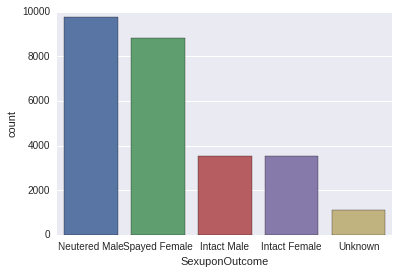

In [37]:
sns.countplot(x = "SexuponOutcome", data = train)

I'm thinking that these should be split into the following 2 variables instead of being in a single variable:

* Sex - Male / Female
* NeuteredSprayed - True / False

There is probably an interaction between these two variables, so some models (such as logistic regression) would need that interaction term left in, whereas other models (random forests) could discover these interactions.

In [38]:
def create_sex_variables(SexuponOutcome):
    results = []
    for row in SexuponOutcome:
        row = row.split(' ')
        if len(row) == 1:
            row = ['Unknown', 'Unknown']
        results.append(row)
    return zip(*[['Neutered', x[1]] if x[0] == 'Spayed' else x for x in results])

# 1 NA value, fill it in with 'Unknown'
NeuteredSprayed, Sex =create_sex_variables(list(train['SexuponOutcome'].fillna('Unknown')))
train['NeuteredSprayed'] = NeuteredSprayed
train['Sex'] = Sex
train.drop(['SexuponOutcome'], axis = 1, inplace = True)

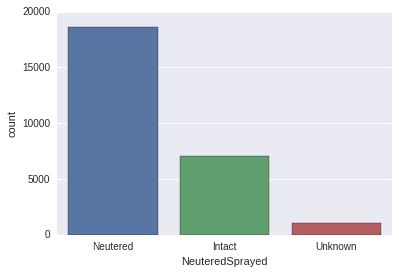

In [42]:
sns.countplot(x = "NeuteredSprayed", data = train)

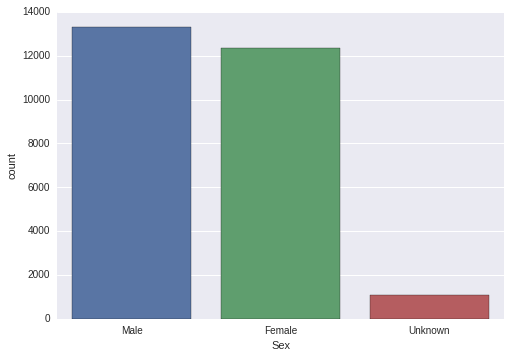

In [11]:
sns.countplot(x = "Sex", data = train)

### `AgeuponOutcome` 

Should be transformed into a numerical variable. There are 18 NAs - given how few, let's not worry too much about them and just impute the mean.

In [12]:
def create_age_in_years(ages):
    results = []
    units = {'days': 365.0, 'weeks': 52.0, 'months': 12.0}
    for age in ages:
        if age == 'NA':
            results.append('NA')
        else:
            duration, unit = age.split(' ')
            results.append(float(duration) / units.get(unit, 1.0))
    impute = np.mean([age for age in results if age != 'NA'])
    return [age if age != 'NA' else impute for age in results]

ages = create_age_in_years(list(train['AgeuponOutcome'].fillna('NA')))
train['Age'] = ages
train.drop(['AgeuponOutcome'], axis = 1, inplace = True)

Look at the distribution of ages:

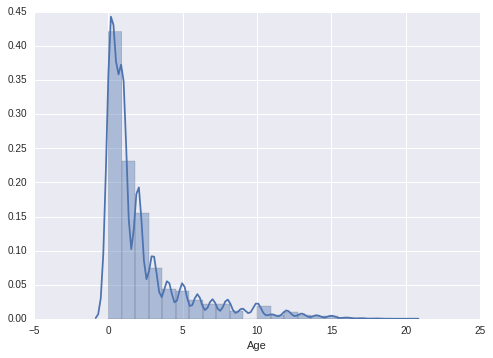

In [13]:
sns.distplot(train['Age'], bins = 22)

The right skew makes sense in the context of age. Let's quickly take a look at how age affects outcome:

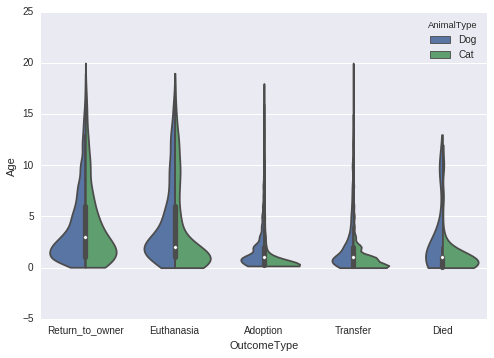

In [18]:
sns.violinplot(x = "OutcomeType", y = "Age", hue = "AnimalType", data = train, cut = 0, split = True)

Animals returned to their owners tend to be slightly older.

### `DateTime`

We want to split this into multiple variables:

* Year, month, day of the week, time (morning, afternoon, evening, night)

In [44]:
x = list(train['DateTime'])[0]
print x

2014-02-12 18:22:00


In [26]:
datetime.strptime(x)

AttributeError: 'module' object has no attribute 'strptime'

### `Breed`

Nubmer of distinct breeds:

In [43]:
len(train['Breed'].unique())

1380

Breed only makes sense in the context of the animal species, of `AnimalType`

In [ ]:
print 'Number of cat breeds:', len(train[train['AnimalType'] == 'Cat']['Breed'].unique())
print 'Number of dog breeds:', len(train[train['AnimalType'] == 'Dog']['Breed'].unique())

Given the massive number of breeds (mostly for dogs) I am worried about overfitting w/ regard to breed.

In [ ]:
#train.groupby('Breed').size().reset_index()[0]
sns.distplot(train[train['AnimalType'] == 'Cat'].groupby('Breed').size().reset_index()[0], bins = 100)

### `Color`

I'm guessing that color's affect on the outcome is sometimes dependent on the animal type, and sometimes not, as in some colors may be appreciated across enmails, while some may be animal specific. Given the likely interactions between variables I would consider a model that considers interactions (neural networks, decisions trees) vs. a model that doesn't take these interactions into account automatically (logistic regression, KNN).

In [ ]:
print 'Number of colors:', len(train['Color'].unique())